# Computational parameters and convergence

Discussion of the computational parameters in a TEMPO or PT-TEMPO computation and establishing the accuracy of results

- [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/) (runs in browser),
- [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/parameters.ipynb), or
- read through the text below and code along.

The following packages will be required

In [ ]:
import sys
sys.path.insert(0,'..')

import oqupy
import numpy as np
import matplotlib.pyplot as plt

The OQuPy version should be `>=0.5.0`

In [5]:
oqupy.__version__

'0.4.0'

# Introduction - numerical exactness and computational parameters
The TEMPO and PT-TEMPO methods are numerically exact meaning no approximations are required in their derivation. Error only arises in their numerical implementation, being controlled by a set of computational parameters. Hence the error can, in principle (at least up to machine precision), be made as small as desired by tuning those numerical parameters. In this tutorial we discuss how this is done to derive accurate results at manageable computational costs.

As introduced in the [Quickstart](https://oqupy.readthedocs.io/en/latest/pages/tutorials/quickstart.html) tutorial a standard TEMPO or PT-TEMPO computation has three main computational parameters:

1. A memory cut-off `tcut`, which must be long enough to capture non-Markovian effects of the environment
2. A timestep length `dt`, which must be short enough to avoid Trotter error and provide a sufficient resolution of the system dynamics
3. A precision `epsrel`, which must be small enough such that the numerical compression (singular value truncation) does not incur physical error

In order to verify the accuracy of a calculation, convergence should be established under all three parameters (increasing `tcut`; decreasing `dt` and `epsrel`). The challenge is that these parameters cannot be considered in isolation of each other, and a balance must be struck between accuracy and computational cost. A strategy that we suggest is to firstly determine a suitable `tcut` with rough values of `dt` and `epsrel`, then determine convergence under `dt->0`, and finally check `epsrel`.

To get an understanding of the kind of issues that can arise in setting each computational parameter, we look at several example calculations. Note these calculations will be more demanding than those in other tutorials and so may not be suitable to run in a Binder instance. If you want to run them on your own device, you can either copy the code as you go along or [download the .ipynb file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/parameters.ipynb) to run in a local jupyter notebook session. 
Plots and runtimes for each calculation will be provided below, however.

We initially use the TEMPO method only. Additional considerations for PT-TEMPO will be given in a later section.

# Choosing `tcut`
## Example - memory effects in a dissipative spin boson model
We firstly define a spin-boson model similar to that in the Quickstart tutorial, but with a finite temperature environment and a small additional incoherent dissipation of the spin.

In [9]:
sigma_x = oqupy.operators.sigma('x')
sigma_y = oqupy.operators.sigma('y')
sigma_z = oqupy.operators.sigma('z')
sigma_m = oqupy.operators.sigma('-')

omega_cutoff = 2.5
alpha = 0.8
T = 0.2
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=omega_cutoff,
                                cutoff_type='exponential',
                                temperature=T)
bath = oqupy.Bath(0.5 * sigma_z, correlations)
Omega = 2.0
Gamma = 0.02
system = oqupy.System(0.5 * Omega * sigma_x,
                      gammas=[Gamma],
                      lindblad_operators=[sigma_m])

t_start = 0.0
t_end = 5.0

To determine a suitable set of computational parameters for `t_start<=t<=t_end`, a good place to start is with a call to the `guess_tempo_parameters` function:

In [3]:
guessed_paramsA = oqupy.guess_tempo_parameters(bath=bath,
                                              start_time=t_start,
                                              end_time=t_end,
                                              tolerance=0.01)
print(guessed_paramsA)

../oqupy/tempo.py:902: UserWarning: Estimating TEMPO parameters. No guarantee subsequent dynamics calculations are converged. Please refer to the TEMPO documentation and check convergence by varying the parameters manually.
  warnings.warn(GUESS_WARNING_MSG, UserWarning)


----------------------------------------------
TempoParameters object: Roughly estimated parameters
 Estimated with 'guess_tempo_parameters()' based on bath correlations.
  dt                   = 0.125 
  tcut [dkmax]         = 2.5 [20] 
  epsrel               = 6.9029694689331e-05 
  add_correlation_time = None 



As indicated in the description of this object, the parameters were estimated by anaylsing the correlations of `bath`, which are discussed further below. 

From the suggested parameters, we focus on `tcut` first, assuming the values of `dt` and `epsrel` are reasonable to work with. To do so we compare results at the recommend `tcut` to those calcualted at a considerable smaller (`1.25`) and larger (`5.0`) value of this parameter, starting from the spin-up state:

--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:00
Elapsed time: 0.6s
--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:00
Elapsed time: 1.0s
--> TEMPO computation:
100.0%   40 of   40 [########################################] 00:00:01
Elapsed time: 1.2s


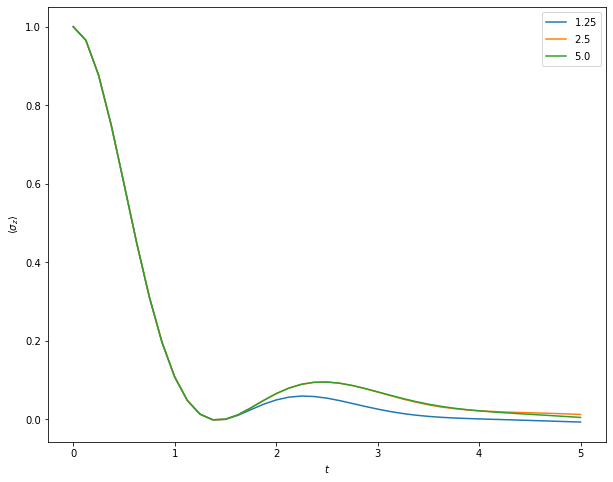

In [11]:
initial_state = oqupy.operators.spin_dm('z+')

plt.figure(figsize=(10,8))
for tcut in [1.25,2.5,5.0]:
    params = oqupy.TempoParameters(dt=0.125, epsrel=6.9e-05, tcut=tcut)
    dynamics = oqupy.tempo_compute(system=system,
                                   bath=bath,
                                   initial_state=initial_state,
                                   start_time=t_start,
                                   end_time=t_end,
                                   parameters=params)
    t, s_z = dynamics.expectations(sigma_z, real=True)
    plt.plot(t, s_z, label=r'${}$'.format(tcut))
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.legend()

We see that `tcut=2.5` (orange) does very well, matching `tcut=5.0` (green) until very close to end of the simulation. We know the latter should capture the actual result, because `tcut=5.0=t_end` means no memory cutoff was made! In general it is not always necessary to make a finite memory approximation if, for example, one is interested in short-time dynamics only. This can be specified by setting `tcut=None` - just be aware this will likey make computation to long times (i.e. many hundreds of timesteps) infeasible.

The `tcut=1.25` result matches the other two exactly until `t=1.25`, as it must (no memory approximation is made before then), but diverges shorlty afterwards. On the other hand the cost using the larger `tcut=2.5` was a longer computation: `1.0s` vs `0.6s` above. This example presented a trivial computation, but in real calculations the computatoinal time will have to be considered. It may be that an intermediary value of `tcut` provides a satisfactory approximation - depending on your required precision - with a more favourable cost: the TEMPO computation scales _linearly_ with the number of steps included in the memory cutoff.

### A word of warning

`guess_tempo_parameters` provides a reasonable starting point for many cases, but it is only a guess. You should always verify the results against a larger `tcut`, whilst you may also want to consider smaller `tcut` to reduce the computational requirements according to the hardware avaiable. Similar applies to checking convergence under `dt` and `epsrel`.

Also, note we only inspected the expectations $\langle \sigma_z \rangle$. To be most thorough all unique components of the state matrices should be checked, or at least those observables you are intending to study. So if you were interested in the coherences as well as the populations, you would want to add calls to calculate $\langle \sigma_x \rangle$, $\langle \sigma_y \rangle$ above (you can check convergence at `tcut=2.5` is satisfied for the above example).

## Discussion - environment correlations
So what influences the required `tcut`? The physically relevant timescale is that for the decay of correlations in the environment. We can inspect these directly for the parameters above using the `oqupy.helpers.plot_correlations_with_parameters` function:

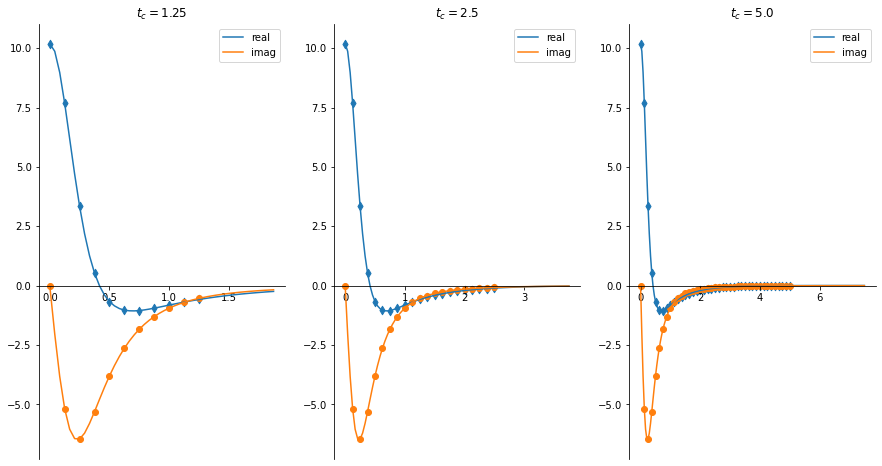

In [12]:
fig, axes = plt.subplots(1,3, figsize=(15,8))
for i, tcut in enumerate([1.25,2.5,5.0]):
    params = oqupy.TempoParameters(dt=0.125, epsrel=6.9e-05, tcut=tcut)
    oqupy.helpers.plot_correlations_with_parameters(bath.correlations, params, ax=axes[i])
    axes[i].set_title(r'$t_c={}$'.format(tcut))

These show the real and imaginary parts of the bath autocorrelation function, with markers indicating samples of spacing `dt`. We see that correlations have not fully decayed by `t=1.25` (left), but have - at least by eye - by `t=2.5`. It indeed seems like `tcut` around this value would be a good choice.

The autocorrelation function depends on the properties of the bath: the form the spectral density, the cutoff and the temperature. These are accounted for by the `guess_tempo_parameters` function, which is really analysing the error in performing integrals of this functions. The `tolerance` parameter specifies the maximum absolute error permitted, and currently has a default value of `3.9e-3` (hence `tolerance=0.01` made for slightly 'easier' parameters).

Note however what is observed in the system dynamics also depends the bath coupling operator and strength (`alpha`), and that these are _not_ taken into account by the guessing function. Generally, the nature of the intrinsic system dynamics (see below) and initial state preparation has to be considered. 

Finally, the guessing function uses specified `start_time` and `end_time` to come up with parameters providing a manageable computation time over a timescale `end_time-start_time`, so make sure to set these to reflect those you actually intend to use in calculations.  


# Choosing `dt`
## Example - convergence for a dissipative spin boson model
Continuing with the previous example, we now investigate `dt`.
In fact, the results are already quite well converged. We verify this by trying smaller `dt`
RESULTS
What about if we now increased the system energies signifcantly? Guess doesn't change, yet can see coarse graining (may need to modify exxample to see this). To accomodate this, can pass sytem object. Here only is a matter of resolution, which you probably could have adjusted by eye. In a later example we show a more interesting case where does effect dynamics.


What affects dt? In general leading requirement is trotter error commutator. Note nethier fuess call checks this. Normally this is sufficient, but in the case of fast system dynamics... see coherent example (possibly move this text there)
have to consider memory cut-off, scale linear so smaller dt means more steps

Now discuss esprel, dt and tcut obvious changes to cmoputation, cubic.. again check precision for this example

## Resolving fast system dynamics

# Choosing `esprel`
## Example - convergence for the spin boson models
## Computational cost degeneracies

# Additional computational parameters
Unlikely you will need to change these, but for information
### Further information
- possible to specify dkmax not tcut, just note then depends on dt. Has advantage of pinning computational cost of memory approximation, but on the other hand not physical cutoff
- no clever way to handle mean-field system object
- unique = False

# Considerations for PT-TEMPO
## dkmax anomaly 